# Sales of Champagne for the Perrin Freres Label

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima.arima import CHTest


import warnings
warnings.filterwarnings('ignore')

In [3]:
url1 = ('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly_champagne_sales.csv')

df = pd.read_csv(url1)

df

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946
...,...,...
100,1972-05,4618
101,1972-06,5312
102,1972-07,4298
103,1972-08,1413


In [4]:
df['Month'] = pd.to_datetime(df['Month'])
df = df.set_index(['Month'])

df.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


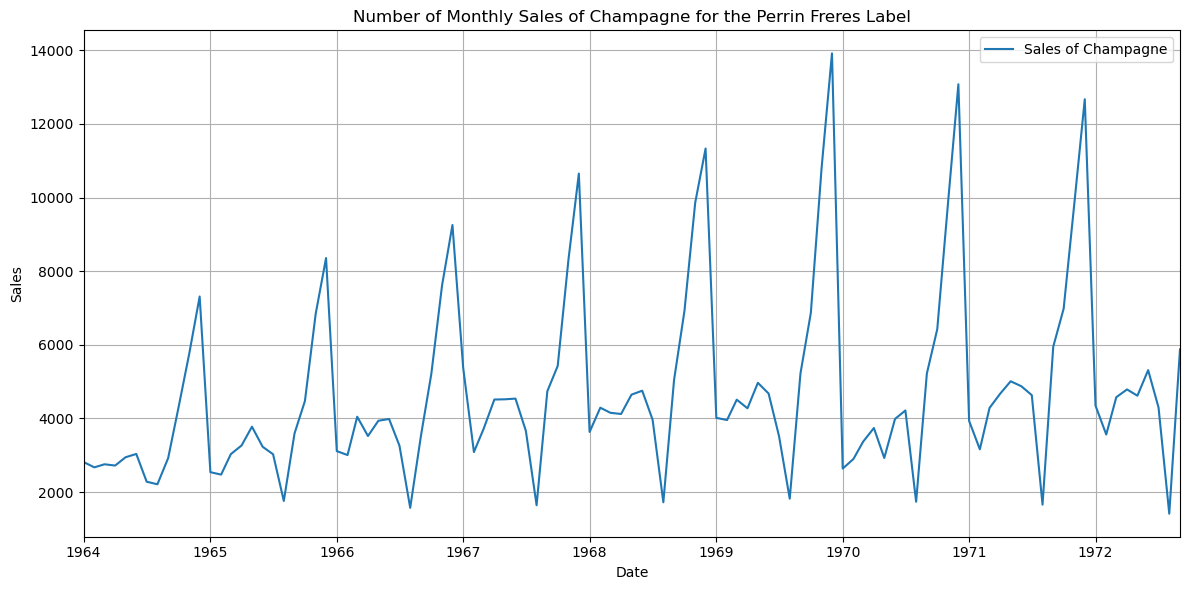

In [5]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

plt.plot(df.index, df['Sales'], label='Sales of Champagne')     

plt.title('Number of Monthly Sales of Champagne for the Perrin Freres Label')                      
plt.xlabel('Date')                                        
plt.ylabel('Sales')  
plt.xlim(pd.to_datetime('1964-01-01'), pd.to_datetime('1972-09-01'))
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show()

In [6]:
# Convert to datetime for the comparison
train = df[df.index < pd.to_datetime('1972-01-01')]     # All data before March
test = df[df.index >= pd.to_datetime('1972-01-01')]     # All data in March and beyond

# Show the results
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print()
train.tail(), print(), test.head()

Train shape: (96, 1)
Test shape: (9, 1)




(            Sales
 Month            
 1971-08-01   1659
 1971-09-01   5951
 1971-10-01   6981
 1971-11-01   9851
 1971-12-01  12670,
 None,
             Sales
 Month            
 1972-01-01   4348
 1972-02-01   3564
 1972-03-01   4577
 1972-04-01   4788
 1972-05-01   4618)

In [7]:
champ_series = train['Sales']

In [8]:
def determine_nonseasonal_d(series, max_d=2, alpha=0.05):

    d = 0

    adf_result = adfuller(series)                # Run ADF test on the original series
    p_value = adf_result[1]
    print(f"d = {d} | ADF Statistic = {adf_result[0]:.4f}, p-value = {p_value:.4f}")

    if p_value < alpha:                          # If the original series is stationary
        
        return d
        
    else:
        while p_value > alpha and d < max_d:
            d += 1
            series = np.diff(series, n=1)        # Perform first-order differencing
            ad_fuller_result1 = adfuller(series)  
            p_value = ad_fuller_result1[1]
            print(f"d = {d} | ADF Statistic = {ad_fuller_result1[0]:.4f}, p-value = {p_value:.4f}")   
            
        return d  

d = determine_nonseasonal_d(champ_series)
print(f"\nNon-seasonal differencing term (d): {d}")

d = 0 | ADF Statistic = -1.6206, p-value = 0.4724
d = 1 | ADF Statistic = -24.7897, p-value = 0.0000

Non-seasonal differencing term (d): 1


In [9]:
from pmdarima.arima import nsdiffs

def determine_seasonal_D(series, m=12):
    
    # Get seasonal differencing terms using CH and OCSB tests
    D = max(nsdiffs(series, m=m, test='ch'),
            nsdiffs(series, m=m, test='ocsb'))

    return D

for m in  [4, 7, 12, 24, 30, 52]:

    D = determine_seasonal_D(champ_series, m)
    print(f'Seasonal differencing term (D) for {m}: {D}')

Seasonal differencing term (D) for 4: 0
Seasonal differencing term (D) for 7: 0
Seasonal differencing term (D) for 12: 1
Seasonal differencing term (D) for 24: 1
Seasonal differencing term (D) for 30: 0
Seasonal differencing term (D) for 52: 0


In [10]:
from pmdarima.arima import nsdiffs

D = nsdiffs(champ_series, m=12, test='ch') # Canova-Hansen Test (ch) is designed for monthly or quarterly data.
print("Seasonal differencing term (D):", D)

Seasonal differencing term (D): 0


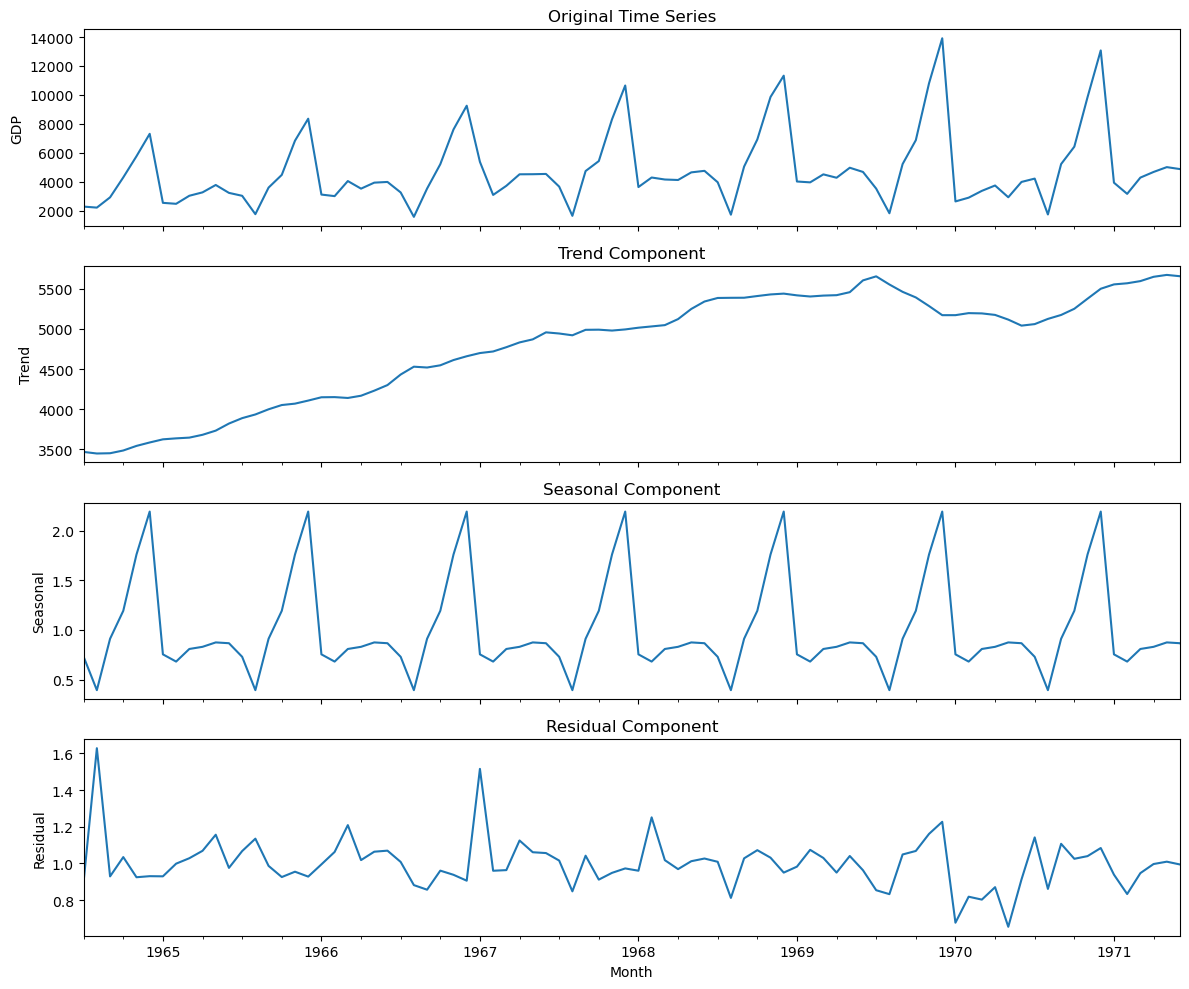

In [11]:
result = seasonal_decompose(champ_series, model='multiplicative', period=12)

trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()


# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

result.observed.plot(ax=axes[0], title="Original Time Series")
axes[0].set_ylabel('GDP')

trend.plot(ax=axes[1], title="Trend Component")
axes[1].set_ylabel('Trend')

seasonal.plot(ax=axes[2], title="Seasonal Component")
axes[2].set_ylabel('Seasonal')

residual.plot(ax=axes[3], title="Residual Component")
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

In [12]:
# Perform a full search over the same grid as your manual SARIMAX model
auto_model = pm.auto_arima(
    champ_series,               # The time series data
    seasonal=True,              # Enable seasonal component
    m=12,                       # Seasonal period
    d=1,                        # Set differencing 
    D=0,                        # Set seasonal differencing
    start_p=0, max_p=3,         # p 
    start_q=0, max_q=3,         # q 
    start_P=0, max_P=3,         # P 
    start_Q=0, max_Q=3,         # Q 
    stepwise=False,             # Disable stepwise search (enable full grid search)
    trace=False,                # Print model search progress
    error_action='ignore',      # Ignore errors and continue
    suppress_warnings=True,     # Suppress convergence warnings
    information_criterion='aic' # Use AIC to choose the best model
)

# Print the best model found
print(f"Best model: SARIMA{auto_model.order}{auto_model.seasonal_order}")

Best model: SARIMA(0, 1, 2)(1, 0, 1, 12)


In [13]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]  # Generate Cartesian product of input lists
    return combo                                    # Return the list of combinations


P_ns, Q_ns = [list(range(4))]*2          # Define search ranges for non-seasonal parameters (p, q): each from 0 to 3
P_s, Q_s = [list(range(4))]*2             # Define search ranges for seasonal parameters (P, Q): each from 0 to 3
d = 1
D = 0
S = 12

total = (P_ns[-1] + 1) * (Q_ns[-1] + 1) * (P_s[-1] + 1) * (Q_s[-1]+ 1)
print(f'Total number of models: {total}')

vals = combinator([P_ns, [d], Q_ns, P_s, [D], Q_s])  # Generate all combinations of SARIMA parameter sets

score = {}                                     # Dictionary to store model evaluation metrics

for i, (p, d, q, P, D, Q) in enumerate(vals):  # Iterate over all parameter combinations
    if i % 15 == 0:                            # Print progress every 15 models
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},{S})')

    m = SARIMAX(champ_series,                  # Define SARIMA model with current parameter set
                order=(p,d,q), 
                seasonal_order=(P, D, Q, S),   
                enforce_stationarity=False)    # Allow non-stationary models for broader search

    res = m.fit(disp=0, low_memory=True)       # Fit the model silently

    score[i] = {                               # Store model results and evaluation metrics
        'non-seasonal order': (p, d, q),      
        'seasonal order': (P, D, Q),
        'AIC': res.aic,                        # Akaike Information Criterion
        'AICc': res.aicc,                      # Corrected AIC
        'model': res                           # Fitted model object
    }
print()

pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()

Total number of models: 256
Running model #0 using SARIMA(0,1,0)(0,0,0,12)
Running model #15 using SARIMA(0,1,0)(3,0,3,12)
Running model #30 using SARIMA(0,1,1)(3,0,2,12)
Running model #45 using SARIMA(0,1,2)(3,0,1,12)
Running model #60 using SARIMA(0,1,3)(3,0,0,12)
Running model #75 using SARIMA(1,1,0)(2,0,3,12)
Running model #90 using SARIMA(1,1,1)(2,0,2,12)
Running model #105 using SARIMA(1,1,2)(2,0,1,12)
Running model #120 using SARIMA(1,1,3)(2,0,0,12)
Running model #135 using SARIMA(2,1,0)(1,0,3,12)
Running model #150 using SARIMA(2,1,1)(1,0,2,12)
Running model #165 using SARIMA(2,1,2)(1,0,1,12)
Running model #180 using SARIMA(2,1,3)(1,0,0,12)
Running model #195 using SARIMA(3,1,0)(0,0,3,12)
Running model #210 using SARIMA(3,1,1)(0,0,2,12)
Running model #225 using SARIMA(3,1,2)(0,0,1,12)
Running model #240 using SARIMA(3,1,3)(0,0,0,12)
Running model #255 using SARIMA(3,1,3)(3,0,3,12)



,index,non-seasonal order,seasonal order,AIC,AICc,model
0,63,"(0, 1, 3)","(3, 0, 3)",904.527405,909.527405,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,55,"(0, 1, 3)","(1, 0, 3)",906.295448,909.425883,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,59,"(0, 1, 3)","(2, 0, 3)",911.5818,915.5818,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,43,"(0, 1, 2)","(2, 0, 3)",915.535857,918.599687,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,39,"(0, 1, 2)","(1, 0, 3)",915.565695,917.899029,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


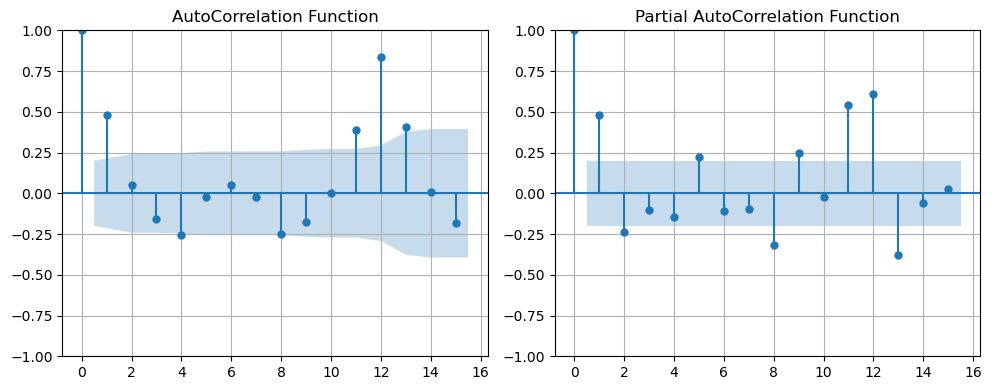

In [14]:
# Create a 1x2 grid for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  

# Interest Rate Data
plot_acf(champ_series, ax=axes[0], lags=15)
axes[0].set_title("AutoCorrelation Function", fontsize=12)
axes[0].grid(True)

# Simulated Random Walk Data
plot_pacf(champ_series, ax=axes[1], lags=15)
axes[1].set_title("Partial AutoCorrelation Function", fontsize=12)
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [15]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_012 = SARIMAX(champ_series,                        # Time series data
                    order=(0, 1, 2),                     # Non-seasonal order (p,d,q)
                    seasonal_order=(1, 0, 1, 12),        # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)          # Allow non-stationary behavior

# Fit the model
model_fit_012 = model_012.fit()

# Display summary of the model
print(model_fit_012.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Sales   No. Observations:                   96
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -645.263
Date:                              Wed, 16 Apr 2025   AIC                           1300.527
Time:                                      16:16:54   BIC                           1312.437
Sample:                                  01-01-1964   HQIC                          1305.302
                                       - 12-01-1971                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7114      0.715     -0.995      0.320      -2.112       0.690
ma.L2         -0.28

In [16]:
# Forecast the next steps time points
forecast_9 = model_fit_012.get_forecast(steps=9)

# Extract predicted mean and confidence intervals
forecast_mean_9 = forecast_9.predicted_mean
conf_int_9 = forecast_9.conf_int()

# Assign forecasts to the test DataFrame
test['Forecast 012'] = forecast_mean_9.values                                # Forecast mean

test['Error 012'] = test['Forecast 012'] - test['Sales']

test['Lower 95% CI 012'] = conf_int_9.iloc[:, 0].values                      # Lower bound
test['Upper 95% CI 012'] = conf_int_9.iloc[:, 1].values                      # Upper bound

# Show the updated test DataFrame
test

,Sales,Forecast 012,Error 012,Lower 95% CI 012,Upper 95% CI 012
Month,,,,,
1972-01-01,4348,3675.902619,-672.097381,2215.515873,5136.289365
1972-02-01,3564,3526.580929,-37.419071,2001.412813,5051.749045
1972-03-01,4577,4493.185482,-83.814518,2968.006413,6018.364552
1972-04-01,4788,4846.505201,58.505201,3321.324712,6371.685689
1972-05-01,4618,4960.889902,342.889902,3435.707893,6486.071910
1972-06-01,5312,5100.731270,-211.268730,3575.547665,6625.914874
1972-07-01,4298,4855.099022,557.099022,3329.913801,6380.284243
1972-08-01,1413,1902.843997,489.843997,377.657148,3428.030847
1972-09-01,5877,6222.379025,345.379025,4697.190539,7747.567512


In [17]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_013 = SARIMAX(champ_series,                        # Time series data
                    order=(0, 1, 3),                     # Non-seasonal order (p,d,q)
                    seasonal_order=(3, 0, 3, 12),        # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)          # Allow non-stationary behavior

# Fit the model
model_fit_013 = model_013.fit()

# Display summary of the model
print(model_fit_013.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   96
Model:             SARIMAX(0, 1, 3)x(3, 0, 3, 12)   Log Likelihood                -442.264
Date:                            Wed, 16 Apr 2025   AIC                            904.527
Time:                                    16:16:59   BIC                            924.601
Sample:                                01-01-1964   HQIC                           912.290
                                     - 12-01-1971                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6301      0.212     -2.967      0.003      -1.046      -0.214
ma.L2         -0.1788      0.236   

In [18]:
# Forecast the next steps time points
forecast_92 = model_fit_013.get_forecast(steps=9)

# Extract predicted mean and confidence intervals
forecast_mean_92 = forecast_92.predicted_mean
conf_int_92 = forecast_92.conf_int()

# Assign forecasts to the test DataFrame
test['Forecast 013'] = forecast_mean_92.values                                # Forecast mean

test['Error 013'] = test['Forecast 013'] - test['Sales']

test['Lower 95% CI 013'] = conf_int_92.iloc[:, 0].values                      # Lower bound
test['Upper 95% CI 013'] = conf_int_92.iloc[:, 1].values                      # Upper bound

# Show the updated test DataFrame
test

,Sales,Forecast 012,Error 012,Lower 95% CI 012,Upper 95% CI 012,Forecast 013,Error 013,Lower 95% CI 013,Upper 95% CI 013
Month,,,,,,,,,
1972-01-01,4348,3675.902619,-672.097381,2215.515873,5136.289365,3407.457977,-940.542023,2032.610351,4782.305604
1972-02-01,3564,3526.580929,-37.419071,2001.412813,5051.749045,3293.416140,-270.583860,1821.281161,4765.551119
1972-03-01,4577,4493.185482,-83.814518,2968.006413,6018.364552,4033.912518,-543.087482,2536.450405,5531.374632
1972-04-01,4788,4846.505201,58.505201,3321.324712,6371.685689,4204.622707,-583.377293,2695.373178,5713.872236
1972-05-01,4618,4960.889902,342.889902,3435.707893,6486.071910,4404.912312,-213.087688,2881.994464,5927.830160
1972-06-01,5312,5100.731270,-211.268730,3575.547665,6625.914874,4620.363597,-691.636403,3084.294546,6156.432648
1972-07-01,4298,4855.099022,557.099022,3329.913801,6380.284243,4010.354806,-287.645194,2461.396588,5559.313024
1972-08-01,1413,1902.843997,489.843997,377.657148,3428.030847,1212.948930,-200.051070,-348.728098,2774.625959
1972-09-01,5877,6222.379025,345.379025,4697.190539,7747.567512,5567.177753,-309.822247,3992.909753,7141.445753


In [19]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Define RMSE function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Metrics for Forecast 012
mae_012 = mean_absolute_error(test['Sales'], test['Forecast 012'])                            # Mean Absolute Error
rmse_012 = rmse(test['Sales'], test['Forecast 012'])                                          # Root Mean Squared Error
mape_012 = mean_absolute_percentage_error(test['Sales'], test['Forecast 012']) * 100          # Mean Absolute Percentage Error (%)

# Metrics for Forecast 013
mae_013 = mean_absolute_error(test['Sales'], test['Forecast 013'])                            # Mean Absolute Error
rmse_013 = rmse(test['Sales'], test['Forecast 013'])                                          # Root Mean Squared Error
mape_013 = mean_absolute_percentage_error(test['Sales'], test['Forecast 013']) * 100          # Mean Absolute Percentage Error (%)

# Combine into dictionaries
metrics_S = {
    'MAE': mae_012,
    'RMSE': rmse_012,
    'MAPE': mape_012,
}

metrics_M = {
    'MAE': mae_013,
    'RMSE': rmse_013,
    'MAPE': mape_013,
}

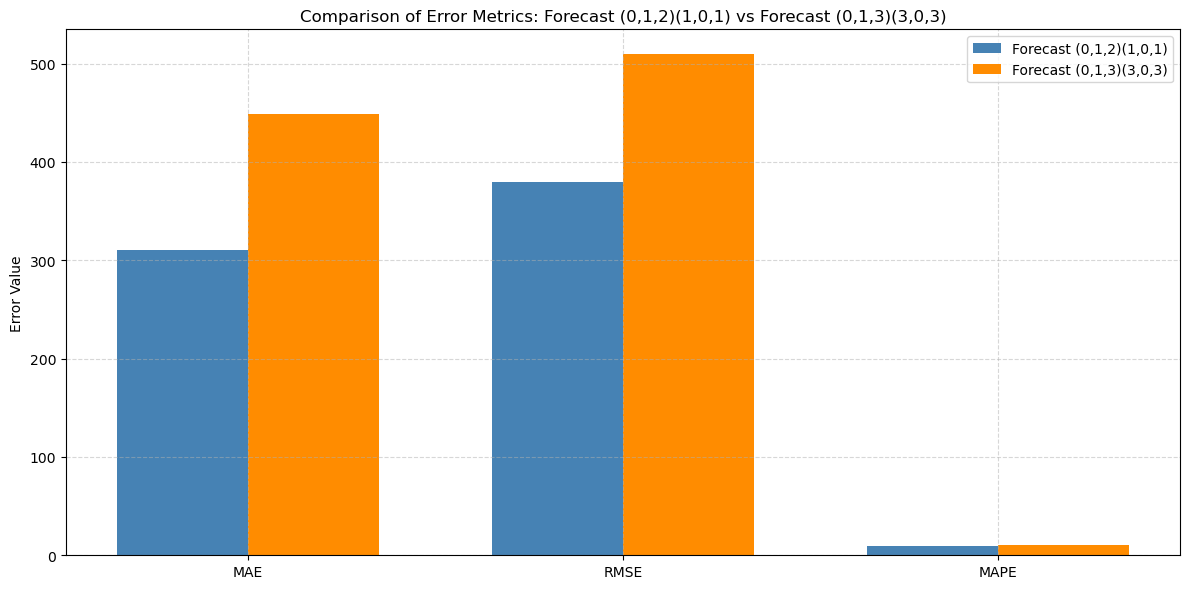

In [20]:
# Plotting
labels = list(metrics_S.keys())
values_S = list(metrics_S.values())
values_M = list(metrics_M.values())

x = range(len(labels))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar([i - width/2 for i in x], values_S, width=width, label='Forecast (0,1,2)(1,0,1)', color='steelblue')
plt.bar([i + width/2 for i in x], values_M, width=width, label='Forecast (0,1,3)(3,0,3)', color='darkorange')

plt.xticks(x, labels)
plt.ylabel("Error Value")
plt.title("Comparison of Error Metrics: Forecast (0,1,2)(1,0,1) vs Forecast (0,1,3)(3,0,3)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [21]:
# Create DataFrame for Error Analysis
comparison_df = pd.DataFrame([metrics_S, metrics_M], index=['Forecast (0,1,2)(1,0,1)', 'Forecast (0,1,3)(3,0,3)']).T
comparison_df

,"Forecast (0,1,2)(1,0,1)","Forecast (0,1,3)(3,0,3)"
MAE,310.924094,448.870362
RMSE,379.380182,509.425089
MAPE,9.385388,10.781137


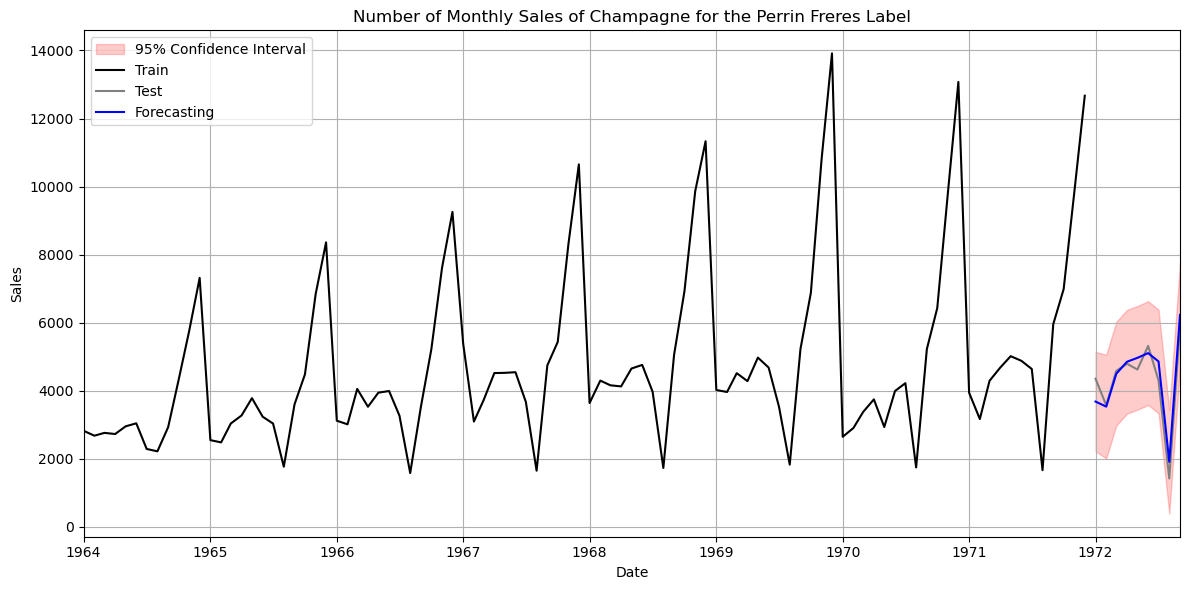

In [22]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_9.iloc[:, 0],     # Lower bound
                 conf_int_9.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['Sales'], label='Train', color='black')                      
plt.plot(test.index, test['Sales'], label='Test', color='gray')     
plt.plot(test.index, test['Forecast 012'], label='Forecasting', color='blue') 

plt.title('Number of Monthly Sales of Champagne for the Perrin Freres Label')                      
plt.xlabel('Date')                                        
plt.ylabel('Sales')  
plt.xlim(pd.to_datetime('1964-01-01'), pd.to_datetime('1972-09-01'))
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show()

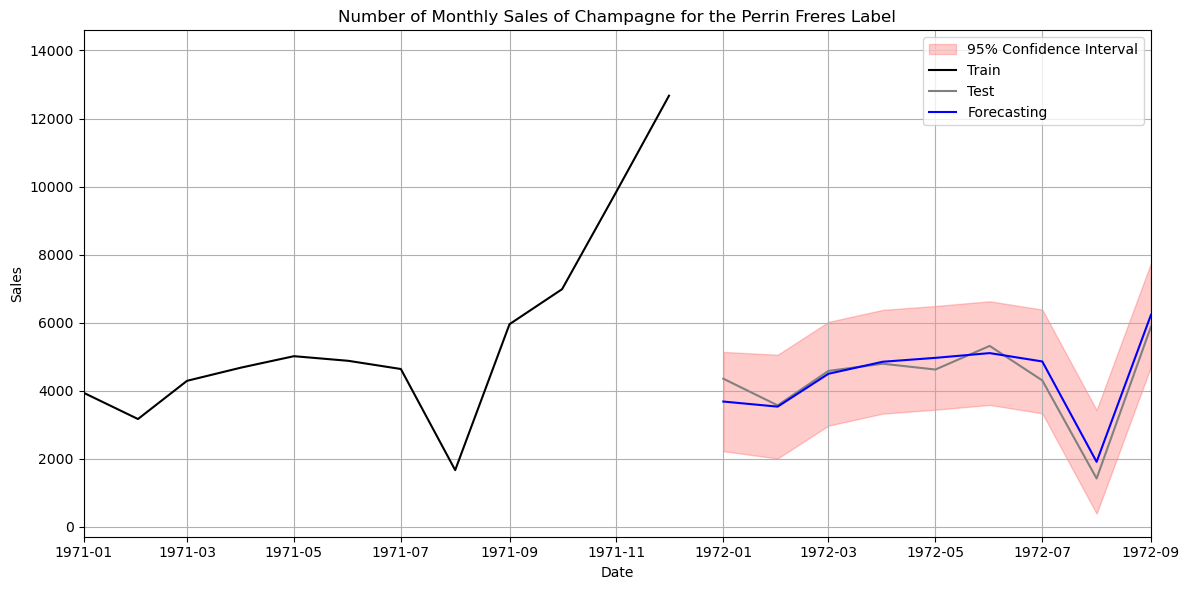

In [23]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_9.iloc[:, 0],     # Lower bound
                 conf_int_9.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['Sales'], label='Train', color='black')                      
plt.plot(test.index, test['Sales'], label='Test', color='gray')     
plt.plot(test.index, test['Forecast 012'], label='Forecasting', color='blue') 

plt.title('Number of Monthly Sales of Champagne for the Perrin Freres Label')                      
plt.xlabel('Date')                                        
plt.ylabel('Sales')  
plt.xlim(pd.to_datetime('1971-01-01'), pd.to_datetime('1972-09-01'))
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show()

In [24]:
# Compute MAPE
actual = test['Sales']
forecast = test['Forecast 012']
mape = np.mean(np.abs((actual - forecast) / actual)) * 100

print(f'MAPE: {mape:.2f}%')

MAPE: 9.39%
